In [114]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch import nn, utils, manual_seed, optim, no_grad, randint
from torch.utils.data import Dataset, DataLoader

In [115]:
manual_seed(44)
n_samples = 1000
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

idx = np.append(
    np.where(train_dataset.targets == 0)[0][:n_samples], np.where(train_dataset.targets == 1)[0][:n_samples]
)
train_dataset.data = train_dataset.data[idx]
train_dataset.targets = train_dataset.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



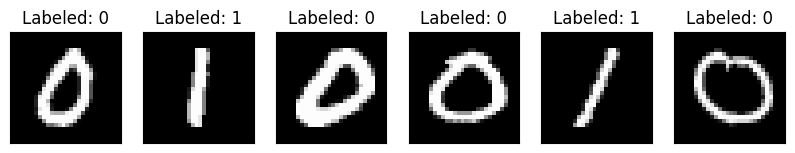

In [116]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [117]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2), 
            nn.Tanh()  # compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)

model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [118]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [119]:
loss_history = []

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            imgs, _ = data
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        loss_history.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}')

In [120]:
train_model(model, train_loader, criterion, optimizer, num_epochs=200)

Epoch 1/200, Loss: 0.0676
Epoch 2/200, Loss: 0.0469
Epoch 3/200, Loss: 0.0470
Epoch 4/200, Loss: 0.0465
Epoch 5/200, Loss: 0.0465
Epoch 6/200, Loss: 0.0466
Epoch 7/200, Loss: 0.0465
Epoch 8/200, Loss: 0.0464
Epoch 9/200, Loss: 0.0462
Epoch 10/200, Loss: 0.0468
Epoch 11/200, Loss: 0.0464
Epoch 12/200, Loss: 0.0462
Epoch 13/200, Loss: 0.0454
Epoch 14/200, Loss: 0.0408
Epoch 15/200, Loss: 0.0387
Epoch 16/200, Loss: 0.0376
Epoch 17/200, Loss: 0.0366
Epoch 18/200, Loss: 0.0361
Epoch 19/200, Loss: 0.0358
Epoch 20/200, Loss: 0.0350
Epoch 21/200, Loss: 0.0345
Epoch 22/200, Loss: 0.0341
Epoch 23/200, Loss: 0.0337
Epoch 24/200, Loss: 0.0334
Epoch 25/200, Loss: 0.0329
Epoch 26/200, Loss: 0.0328
Epoch 27/200, Loss: 0.0322
Epoch 28/200, Loss: 0.0307
Epoch 29/200, Loss: 0.0291
Epoch 30/200, Loss: 0.0279
Epoch 31/200, Loss: 0.0275
Epoch 32/200, Loss: 0.0268
Epoch 33/200, Loss: 0.0268
Epoch 34/200, Loss: 0.0267
Epoch 35/200, Loss: 0.0263
Epoch 36/200, Loss: 0.0261
Epoch 37/200, Loss: 0.0260
Epoch 38/2

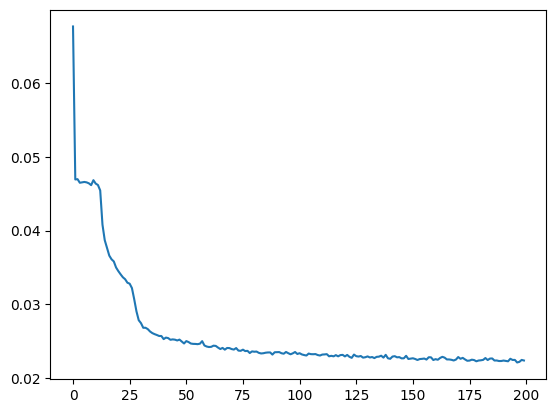

In [121]:
plt.plot(loss_history)
plt.show()

In [122]:
def visualize(model, test_loader):
    model.eval()
    with no_grad():
        dataiter = iter(test_loader)
        images, _ = next(dataiter) 
        outputs = model(images)
        outputs = outputs.view(-1, 1, 28, 28)  # Ensure the outputs are reshaped correctly

        # Set up the plots
        fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,5))
        for orig, reco, ax in zip(images, outputs, axes.flatten()):
            ax.imshow(np.squeeze(orig), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('Original')
            ax.imshow(np.squeeze(reco), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('Reconstructed')

        plt.show()

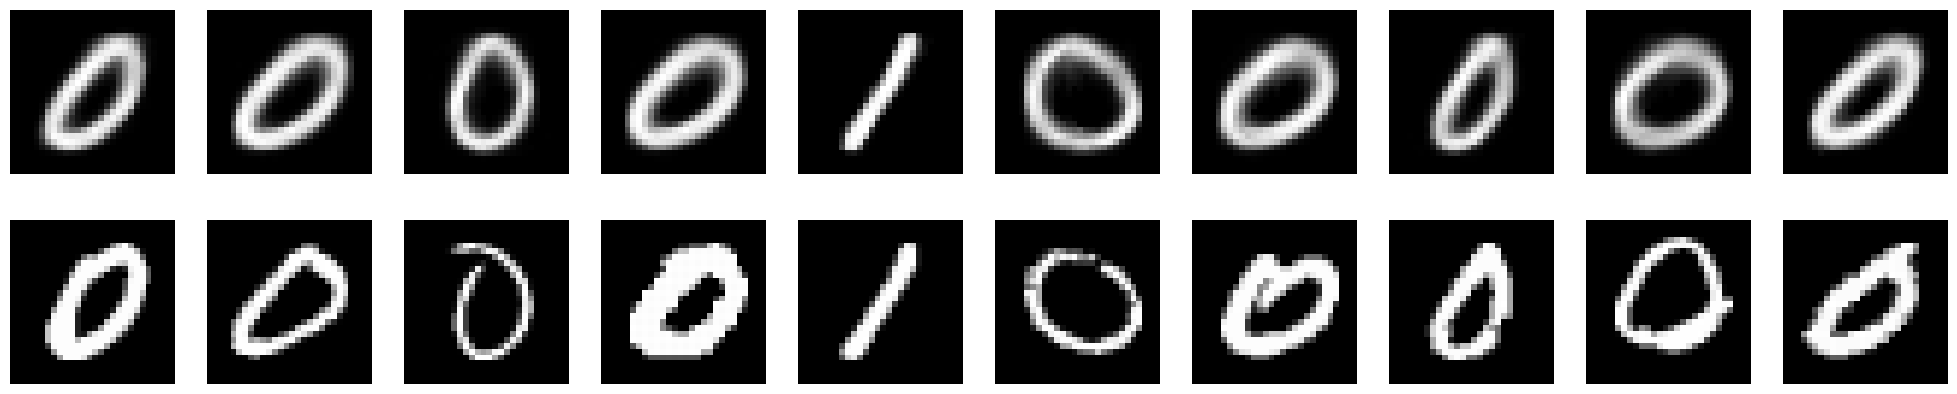

In [123]:
figure = plt.figure(figsize=(25, 5))
cols, rows = 10, 2
for i in range(1, cols + 1):
    sample_idx = randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    output = model(img)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(np.squeeze(output.detach()), cmap="gray")
    figure.add_subplot(rows, cols, i+10)
    plt.axis("off")
    plt.imshow(np.squeeze(img), cmap="gray")
plt.show()